In [1]:
import numpy as np
import pandas as pd

In [2]:
!python --version

Python 3.10.12


In [3]:
# @title 데이터취득
# https://drive.google.com/file/d/15WtPxVqDEeB5jHx7hPCCH2BPFOXN2y1K/view?usp=sharing resizeall
import gdown, os, zipfile

file_id = '15WtPxVqDEeB5jHx7hPCCH2BPFOXN2y1K'
output = 'data.zip'

gdown.download(f'http://drive.google.com/uc?id={file_id}', output, quiet=False)

output_dir = 'furniture'
os.makedirs(output_dir, exist_ok=True)  # 폴더가 없으면 생성

with zipfile.ZipFile(output, 'r') as z:
    z.extractall(output_dir)  # output_dir에 압축 해제
    print(f"압축 해제 완료: {output_dir}")

# 압축 해제된 폴더 내용 확인
print("압축 해제된 파일 및 폴더 목록:")
print(os.listdir(output_dir))


Downloading...
From (original): http://drive.google.com/uc?id=15WtPxVqDEeB5jHx7hPCCH2BPFOXN2y1K
From (redirected): https://drive.google.com/uc?id=15WtPxVqDEeB5jHx7hPCCH2BPFOXN2y1K&confirm=t&uuid=b58b7fdc-cb25-4cc3-82d9-561aeb059c70
To: /content/data.zip
100%|██████████| 194M/194M [00:02<00:00, 73.1MB/s]


압축 해제 완료: furniture
압축 해제된 파일 및 폴더 목록:
['resized_data_all']


In [4]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

def load_data(base_dir='/content/furniture/resized_data_all'):
    images = []
    labels = []
    class_names = []

    # 최상위 디렉토리의 클래스 이름 가져오기
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):  # 클래스 디렉토리인지 확인
            class_names.append(class_name)  # 클래스 이름 추가

            # 클래스 내부의 모든 이미지 탐색
            for root, _, files in os.walk(class_path):
                for file_name in files:
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # 이미지 파일만
                        image_path = os.path.join(root, file_name)
                        images.append(image_path)
                        labels.append(class_name)

    return np.array(images), np.array(labels), class_names

# 데이터 로드
images, labels, class_names = load_data()

# 라벨 인코딩 및 원핫인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# 출력
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: {class_names}")
print(f"Number of Images: {len(images)}")
print(f"Sample Images: {images[:5]}")
print(f"Sample Labels: {labels[:5]}")
# print(f"Sample Labels: {encoded_labels[:5]}")


Number of Classes: 4
Class Names: ['dining_table', 'cabinet', 'sofa', 'chair']
Number of Images: 6196
Sample Images: ['/content/furniture/resized_data_all/dining_table/resized_337.jpg'
 '/content/furniture/resized_data_all/dining_table/resized_908.jpg'
 '/content/furniture/resized_data_all/dining_table/resized_741.jpg'
 '/content/furniture/resized_data_all/dining_table/resized_198.jpg'
 '/content/furniture/resized_data_all/dining_table/resized_797.jpg']
Sample Labels: [2 2 2 2 2]


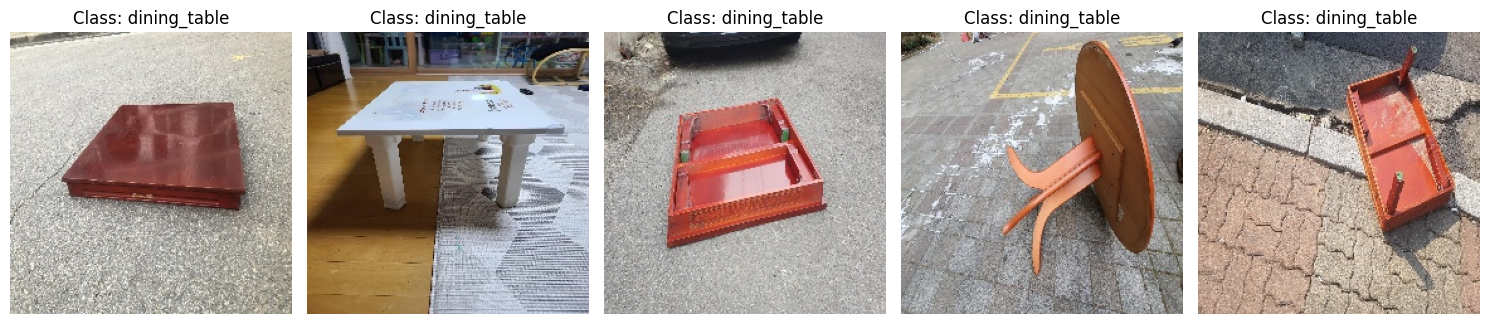

In [5]:
import matplotlib.pyplot as plt
import cv2

def visualize(images, labels, label_encoder, num_samples=5):
    """
    이미지와 라벨을 시각화하여 매칭 여부를 확인하는 함수.
    """
    plt.figure(figsize=(15, 5))

    for i in range(num_samples):
        # 이미지 경로와 라벨 가져오기
        image_path = images[i]
        label = labels[i]

        # 이미지 읽기
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽으므로 RGB로 변환

        # 실제 클래스 이름 가져오기
        class_name = label_encoder.inverse_transform([label])[0]

        # 플롯에 표시
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize(images, labels, label_encoder, num_samples=5)


In [6]:
# @title Sequence 객체 만들기
from tensorflow.keras.utils import Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

class FurnitureSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.preprocess_function = preprocess_function
    self.shuffle = shuffle
    self.indexes = np.arange(len(images))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size)) # 배치 사이즈만큼 돌리기

  def __getitem__(self, index): #index번재 배치 데이터 반환
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None # 예측에는 라벨 필요없음

    # 배치 크기에 맞는 배열 초기화 (리사이즈된 결과를 저장할 새로운 배열 필요)
    batch_images = np.zeros((this_batch_images.shape[0], self.image_size, self.image_size, 3), dtype=np.float32)

    for i, image_path in enumerate(this_batch_images):
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # 데이터 증강 적용
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image'] # augment 딕셔너리 반환해서, 필요한 데이터(이미지만 추출)만 명시적으로 추출, 데이터 증강 도구는 이미지 외의 데이터를 함께 처리할 수 있어서('mask','bboxes' 등)

      # 전처리
      if self.preprocess_function is not None:
        image = self.preprocess_function(image)

      batch_images[i] = image

    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self): # 에포크 종료 후 데이터 섞기.
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)



In [7]:
# @title 학습/검증/평가셋별로 Sequence객체 설정
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
import albumentations as A

# 데이터 분할
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=0)
tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=0)

# Sequence 객체 생성
train_seq = FurnitureSequence(tr_images, tr_labels, batch_size=32, image_size=224, preprocess_function=preprocess_input, shuffle=True)
val_seq = FurnitureSequence(val_images, val_labels, batch_size=32, image_size=224, preprocess_function=preprocess_input, shuffle=False)
test_seq = FurnitureSequence(test_images, test_labels, batch_size=32, image_size=224, preprocess_function=preprocess_input, shuffle=False)

tr_batch_images, tr_batch_labels = next(iter(train_seq)) # seq객체 next로 보고싶으면 iter객체로 감싸서 볼 수 있고, 배치 이미지를 반환함
print(tr_batch_images.shape, tr_batch_labels.shape)

print(tr_images.shape, val_images.shape,tr_labels.shape, val_labels.shape, test_images.shape, test_labels.shape)

(32, 224, 224, 3) (32,)
(3964,) (992,) (3964,) (992,) (1240,) (1240,)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# @ title 모델 생성
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization

# EfficientNetB0 모델 로드 (ImageNet 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)  # Fully Connected Layer
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)  # 최종 출력층 (4개 클래스)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=output)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,840,871 (18.47 MB)

 Trainable params: 4,797,312 (18.30 MB)

 Non-trainable params: 43,559 (170.16 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 153s 580ms/step - accuracy: 0.6546 - loss: 1.0792 - val_accuracy: 0.8115 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.8757 - loss: 0.3638 - val_accuracy: 0.8720 - val_loss: 0.3658 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9127 - loss: 0.2507 - val_accuracy: 0.8700 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9474 - loss: 0.1414 - val_accuracy: 0.8962 - val_loss: 0.3969 - learning_rate: 0.0010
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9477 - loss: 0.1638
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9476 - loss: 0.1639 - val_accuracy: 0.8881 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.9629 - loss:

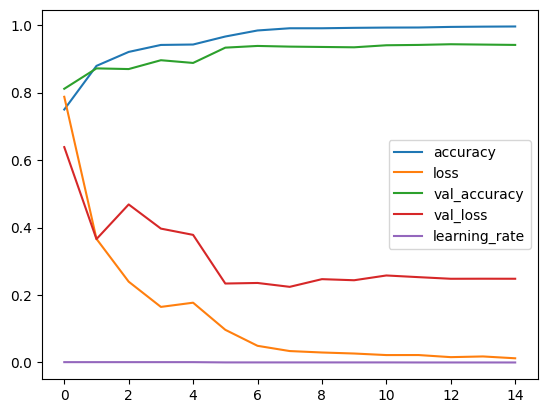

 3/39 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9931 - loss: 0.0661

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.9534 - loss: 0.1822
Test Accuracy: 95.24%


In [9]:
# @title 모델 컴파일/학습 & 미세조정

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 특성추출층 freeze
for layer in model.layers[:5]:
  layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
early_stop = EarlyStopping(patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=30,
    callbacks=[early_stop,reduce_lr],
    verbose=1)

#시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, acc = model.evaluate(test_seq)
loss, acc
print(f"Test Accuracy: {acc * 100:.2f}%")

Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 122s 464ms/step - accuracy: 0.9924 - loss: 0.0243 - val_accuracy: 0.9385 - val_loss: 0.2426 - learning_rate: 1.0000e-04
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 71s 144ms/step - accuracy: 0.9932 - loss: 0.0237 - val_accuracy: 0.9325 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.9893 - loss: 0.0296 - val_accuracy: 0.9385 - val_loss: 0.2697 - learning_rate: 1.0000e-04
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9962 - loss: 0.0182
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9962 - loss: 0.0182 - val_accuracy: 0.9405 - val_loss: 0.2461 - learning_rate: 1.0000e-04
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9893 - loss: 0.0268 - val_accuracy: 0.9395 - val_loss: 0.2492 - learning_rate: 2.0000e-05
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/

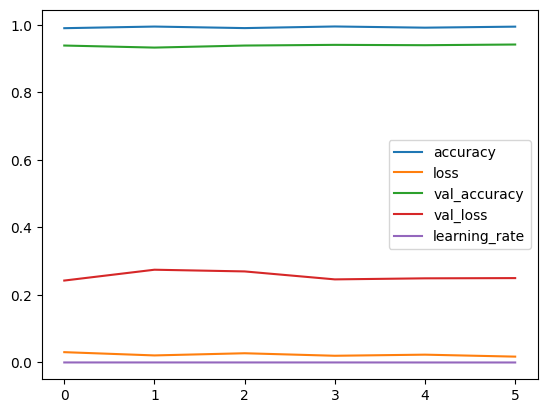

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9527 - loss: 0.2084
Test Accuracy: 95.32%


In [10]:
# @title 미세조정

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# 특성추출층 unfreeze
for layer in model.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

# 콜백 설정
early_stop = EarlyStopping(patience=5, restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=20,
    callbacks=[early_stop,reduce_lr],
    verbose=1)

#시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, acc = model.evaluate(test_seq)
loss, acc
print(f"Test Accuracy: {acc * 100:.2f}%")

In [11]:
print(test_images.dtype)  # 데이터 유형 확인
print(test_images.shape)  # 데이터 구조 확인
print(class_names)
print(type(class_names))
print(test_labels.dtype)
print(test_labels.shape)
print(test_images[:5])

<U65
(1240,)
['dining_table', 'cabinet', 'sofa', 'chair']
<class 'list'>
int64
(1240,)
['/content/furniture/resized_data_all/cabinet/resized_695.jpg'
 '/content/furniture/resized_data_all/dining_table/resized_1331.jpg'
 '/content/furniture/resized_data_all/chair/resized_973.jpg'
 '/content/furniture/resized_data_all/cabinet/resized_668.jpg'
 '/content/furniture/resized_data_all/cabinet/resized_334.jpg']


In [13]:
model.save('Efficient.keras')

In [12]:
chair_path = '/content/의자.jpeg'
chair_image = cv2.imread(chair_path)
chair_image = cv2.cvtColor(chair_image, cv2.COLOR_BGR2RGB)
chair_image = chair_image.astype('float32') / 255.0

class_names = ["cabinet", "chair", "table", "sofa"]
chair_label = class_names.index('chair')
chair_label = np.array([chair_label])

furniture_path = np.array([
    '/content/의자.jpeg',
    '/content/서랍장.jpeg',
    '/content/장롱.jpeg',
    '/content/밥상.jpeg',
    '/content/침대.jpeg',
    '/content/소파.jpeg'
])

test2_seq = FurnitureSequence(
    furniture_path,
    None,
    batch_size=len(furniture_path),  # 단일 샘플 배치
    image_size=224,
    preprocess_function=preprocess_input,
    shuffle=False
)


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
pred_proba = model.predict(test2_seq)
print(pred_proba)
print(np.argmax(pred_proba, axis=1))

pred_classes = [class_names[idx] for idx in np.argmax(pred_proba, axis=1).squeeze()]

def show_images(images, labels):
  fig, axs = plt.subplots(1, len(images), figsize=(20,6))

  for i in range(len(images)):
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].imshow(image)
    axs[i].set_title(f'ptedicted: {labels[i]}')
    axs[i].axis('off')

  plt.show()

show_images(furniture_path, pred_classes)